## Gated Recurrent Unit (GRU) neural network model

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
SAVING_DIR = r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\outputs\models'

import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import sklearn.metrics as metrics # for model evaluation 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df_by_hour = pd.read_csv(r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\data\processed\cleaned_df_final.csv').drop(['index'], axis=1)
df_by_hour.head(2)

,date,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
0,2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
1,2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [3]:
df_by_hour.set_index('date', inplace=True)
df_by_hour.head(2)

,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,0.000708,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,0.000517,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [4]:
# sub-selecting data 
df_by_hour= df_by_hour.loc['2019-03':'2019-06']
df_by_hour.drop(['Day'], axis=1, inplace =True)

In [5]:
df_by_hour.columns

Index(['Pressure', 'Humidity', 'Temperature', 'NO_s', 'NO2_s', 'O3_s', 'CO_s',
       'NO', 'NO2', 'O3', 'CO', 'Hour', 'Day_of_week', 'Day_of_month', 'Month',
       'is_weekday', 'daypart', 'Season', 'NO_lag_feature', 'NO2_lag_feature',
       'CO_lag_feature', 'O3_lag_feature', 'NO_rolling_mean',
       'NO2_rolling_mean', 'CO_rolling_mean', 'O3_rolling_mean',
       'NO_rolling_min', 'NO2_rolling_min', 'CO_rolling_min', 'O3_rolling_min',
       'NO_rolling_max', 'NO2_rolling_max', 'CO_rolling_max', 'O3_rolling_max',
       'NO_rolling_std', 'NO2_rolling_std', 'CO_rolling_std',
       'O3_rolling_std'],
      dtype='object')

### Machine learning data preparation 

In [6]:
# Spliting the data into train and test sets
train_size = int(len(df_by_hour)*0.8)
test_size = len(df_by_hour) - train_size

train, test = df_by_hour.iloc[0:train_size], df_by_hour.iloc[train_size:len(df_by_hour)]

print(train.shape, test.shape)

(1761, 38) (441, 38)


In [7]:
# Scaling of data

# creating variables for list of columns with scaler
feature_columns = ['Pressure', 'Humidity', 'Temperature','NO', 'NO2', 'CO',
         'NO_s', 'NO2_s','O3_s', 'CO_s', 'Hour','Day_of_week', 'is_weekday', 'daypart',
        'NO_rolling_mean', 'NO2_rolling_mean', 'CO_rolling_mean',
        'O3_rolling_mean', 'NO_rolling_min', 'NO2_rolling_min',
        'CO_rolling_min', 'O3_rolling_min', 'NO_rolling_max', 'NO2_rolling_max',
        'CO_rolling_max', 'O3_rolling_max',
        'O3_rolling_std']
#target_columns = ['NO']

feature_transformer = MinMaxScaler()
NO_transformer = MinMaxScaler()

# fit the scaler on training data
feature_transformer = feature_transformer.fit(train[feature_columns])
NO_transformer = NO_transformer.fit(train[['NO']])

In [8]:
train.loc[:, feature_columns] = feature_transformer.transform(train[feature_columns])
train['NO'] = NO_transformer.transform(train[['NO']])

test.loc[:, feature_columns] = feature_transformer.transform(test[feature_columns])
test['NO'] = NO_transformer.transform(test[['NO']])

In [9]:
# Making the time series data into sub sequences by writing a funciton
# split a multivariate sequene into samples
import numpy as np 
def create_dataset(X, y, time_steps=1): # X=features, y=labels, time_steps= history of sequence
    Xs, ys = [], [] # create two lists
    for i in range(len(X) - time_steps): #loops for the subsequent steps
        values = X.iloc[i: (i + time_steps)]
        Xs.append(values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#x = np.asarray(x).astype('float32')
#x_train = np.asarray(x_train).astype(np.float32)
#y_train = np.asarray(y_train).astype(np.float32)

In [10]:
# Specify number of time steps
TIME_STEPS = 48 # history of 24 hours to predict for the next 24 hours

# Creating actual taining and test dataset
# Reshaping to samples, time_steps and n_features
X_train, y_train = create_dataset(train, train.NO, time_steps= TIME_STEPS)
X_test, y_test = create_dataset(test, test.NO, time_steps= TIME_STEPS)

In [11]:
# printing number of samples, number of time_steps and number of features
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1713, 48, 38) (1713,)
(393, 48, 38) (393,)


In [12]:
# print the first sequence
#X_test[0].shape
X_test[0][0].shape, X_train[0][0].shape

((38,), (38,))

In [13]:
# Creating function for deep learning model

def create_model(optimizer='adam', dropout_rate=0.2, activation='relu'):
    model_gru = keras.Sequential()

    model_gru.add(keras.layers.GRU(units = 128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_gru.add(keras.layers.Dropout(rate=0.2)) # add dropout layer

    model_gru.add(keras.layers.Dense(units=1))

    # compile the model
    model_gru.compile(loss='mean_squared_error', optimizer='adam')
    
    return model_gru


model_gru = create_model()
model_gru.summary()

# Saving the model
my_path = SAVING_DIR
my_file = "model_GRU.h5"
model_gru.save_weights(os.path.join(my_path, my_file))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               64512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 64,641
Trainable params: 64,641
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
seed = 7
np.random.seed(seed)

gru_history = model_gru.fit(X_train, y_train, 
                        epochs = 30,
                        batch_size=32,
                        validation_split=0.3,
                        shuffle=False
                       )

Train on 1199 samples, validate on 514 samples
Epoch 1/30
1199/1199 [==============================] - 4s 3ms/sample - loss: 2.4296 - val_loss: 1.3722
Epoch 2/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 1.5320 - val_loss: 1.3389
Epoch 3/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 1.0704 - val_loss: 1.5904
Epoch 4/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 0.8436 - val_loss: 0.7591
Epoch 5/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 0.5991 - val_loss: 0.3035
Epoch 6/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 0.5623 - val_loss: 0.5946
Epoch 7/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 0.5091 - val_loss: 0.3777
Epoch 8/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 0.5122 - val_loss: 0.5314
Epoch 9/30
1199/1199 [==============================] - 2s 2ms/sample - loss: 0.5129 - val_loss: 0.3426
Epoch 10/30
1199/

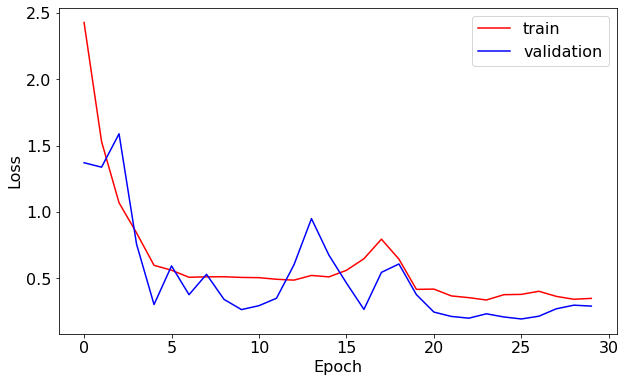

In [15]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(gru_history.history['loss'], 'r', label='train')
plt.plot(gru_history.history['val_loss'], 'b', label='validation')
ax.set_xlabel(r'Epoch', fontsize=16)
ax.set_ylabel(r'Loss', fontsize=16)
ax.legend(fontsize = 16)
ax.tick_params(labelsize=16)


# Save the plot
my_path = SAVING_DIR
my_file = 'GRU_model_NO.png'
plt.savefig(os.path.join(my_path, my_file))

In [16]:
# making prediction
y_pred_gru = model_gru.predict(X_test)

In [17]:
# function for calculating MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))*100

# Model evaluation using mean square error (MSE)
print('r Squared Error:' , metrics.r2_score(y_test, y_pred_gru))
print('Mean Squared Error:' , metrics.mean_squared_error(y_test, y_pred_gru))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_gru)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_gru))
print('MAPE:' , mape(y_test, y_pred_gru))

r Squared Error: 0.920456455014694
Mean Squared Error: 0.3392685138242604
Root Mean Squared Error: 0.5824676075321789
Mean Absolute Error: 0.3918423730091184
MAPE: 181.9113986955655


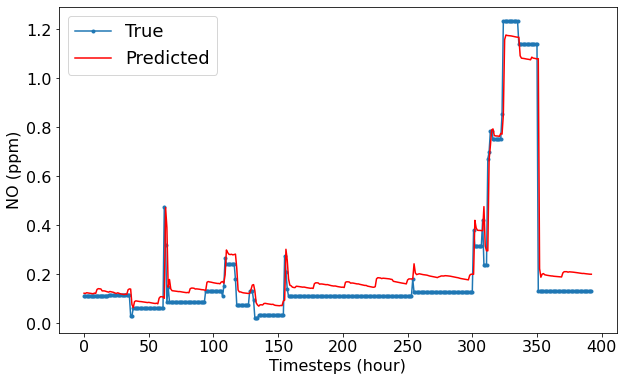

In [18]:
# use inverse the scaler for the feature variable
# invert the X_train, y_train and predicted data
y_train_inv = NO_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = NO_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = NO_transformer.inverse_transform(y_pred_gru)

# plotting the predicted value
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(y_test_inv.flatten(), marker='.', label='True')
plt.plot(y_pred_inv.flatten(), 'r', label='Predicted')

ax.set_xlabel(r'Timesteps (hour)', fontsize=16)
ax.set_ylabel(r'NO (ppm)', fontsize=16)
ax.legend()
ax.tick_params(labelsize=16)
#plt.ylabel('Global_active_power', size=15)
#plt.xlabel('Time step', size=15)
plt.legend(fontsize=18)

my_path = SAVING_DIR
my_file = 'GRU_prediction_NO_1'
plt.savefig(os.path.join(my_path, my_file), dpi=300, bbox_inches='tight')

### Tunning hyperparameter using cross vlaidation : by using GridSearchCV from Scikit-Learn

In [20]:
%%time
seed = 7 # fix random seed for reproducibility
np.random.seed(seed)


# create the sklearn model for the network
model_batch_epoch = KerasRegressor(build_fn=create_model, verbose=1)

# we choose the initializers that came at the top in our previous cross-validation!!
#init_mode = ['glorot_uniform', 'uniform'] 
#layer_size= [32, 64, 128]
batches = [16, 32, 64]
epochs = [20, 30, 40]
#learn_rate= [0.001,0.01, 0.1 ]
dropout_rate=[0.2, 0.3]
optimizer=['Adam', 'RMSProp']
#activation=['sigmoid', 'relu']

# grid search for initializer
param_grid = dict( batch_size=batches, epochs=epochs, dropout_rate=dropout_rate, optimizer=optimizer)
grid = GridSearchCV(estimator=model_batch_epoch,
                    param_grid=param_grid,
                    cv=3)
grid_result = grid.fit(X_train, y_train)

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.3389
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6833
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5610
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5420
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4440
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4209
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4241
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4074
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3660
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3865
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3955
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2176
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4562
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3437
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3134
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3432
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2735
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2248
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2509
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2258
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2294
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2337
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.6035
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7148
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5788
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5183
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4628
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3885
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4003
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3629
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3559
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3660
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3646
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.2742
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6948
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4998
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4756
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4505
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3868
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3752
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3782
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3504 - ETA: 0s - loss:
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3577
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3471
Epoch 12/20
1142/1142 [

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.0319
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4308
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3527
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2765
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2618
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2549
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2498
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2299
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2442
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2281
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2228
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.8962
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7580
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5734
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4874
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4185
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3854
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4174
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3300
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3531
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3782
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3319
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2899
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5565
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4778
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4527
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4459
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3804
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3734
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3631
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3653
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3631
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3552
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.1033
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4835
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3607
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3196
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2725
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2719
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2670
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2553
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2439
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2307
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2124
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2122
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5454
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4546
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4243
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4008
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3937
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3684
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3412
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3455
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3259
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3374
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.6106
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6824
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5384
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4790
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4359
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4131
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4284
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3598
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3605
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3711
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3942
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.9363
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4443
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3245
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2810 0s - l
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2635
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2364
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2319
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2244
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2625
Epoch 10/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2129
Epoch 11/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2365
Epoch 12/30
1142/1142 [===========

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.1682
Epoch 2/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5246
Epoch 3/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4552
Epoch 4/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4921
Epoch 5/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3906
Epoch 6/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3621
Epoch 7/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3658
Epoch 8/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3795
Epoch 9/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3482
Epoch 10/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3454
Epoch 11/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3525
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.4325
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6631
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4925
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4579
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4501
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3852
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3937
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3790
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3582
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3698
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3583
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 4ms/sample - loss: 0.9061
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3989
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3491
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2946
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2994
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2562
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2330
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2519
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2500
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2115
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2358 0s - loss
Epoch 12/40
1142/1142 [========

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.2957
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5813
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4686
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4426
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4319
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3788
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3678
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3615
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3534
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3574
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3426
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 4ms/sample - loss: 1.6747
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6539
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4819
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4643
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4363
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3839
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3929
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3742
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3728
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3545
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3490
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 4ms/sample - loss: 1.3213
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5568
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3272
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3023
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2751
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2595
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2674
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2534
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2602
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2440
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2430
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 6s 5ms/sample - loss: 1.9503
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5926
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4732
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5038
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4160
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3889
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3879
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3700
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3666
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3562
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3235
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2519
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5879
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4965
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4666
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4357
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4194
Epoch 7/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3902
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3585
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3885
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3737
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3255
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.4546
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4313
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3478
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3302
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2928
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2513
Epoch 7/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2471
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2441
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2434
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2284
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2083
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5060
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5986
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4995
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4259
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4303 0s - lo
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3938
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3893
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3513
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3730
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3452
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3153
Epoch 12/20
1142/1142 [==========

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5735 0s - los
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6768
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5354
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4412
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4345
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3935
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3937
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3927
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3583
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3763
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3391
Epoch 12/20
1142/1142 [=========

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.3747
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5227
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3401
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3048
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3166
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2948
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2506
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2748
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2340
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2254
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2245
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.1287
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5585
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4370
Epoch 4/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4393
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3995
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3722
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3595
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3445
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3370
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3606
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3025
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.8266
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6838
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5269
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4598
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4722
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4191
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4008
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4214
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3740
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3829
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3664
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.1972 0s - loss: 2
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6502
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4091
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3394
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3295
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3290
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2791
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2588
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2854
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2476
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2635
Epoch 12/30
1142/1142 [=====

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.5094
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7927
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6492
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5147
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4957
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4255
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4043
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3888
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3778
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3471
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3683
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.6382
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7031
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5412
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4507
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4965
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4218
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3808
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3852
Epoch 9/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3722
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3878
Epoch 11/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3588
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 5s 4ms/sample - loss: 1.1701
Epoch 2/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4477
Epoch 3/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3420
Epoch 4/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2833
Epoch 5/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2777
Epoch 6/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2470
Epoch 7/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2512
Epoch 8/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2379
Epoch 9/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2282
Epoch 10/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2335
Epoch 11/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2154
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2987
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6036
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5032
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4409
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4135
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3915
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3859
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3732 0s - loss: 0.
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3303
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3807
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3227
Epoch 12/30
1142/1142 [====

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.8192
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6188
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5246
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4772
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4092
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3833
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3899 0s - loss: 0
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4004
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3682
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3699
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3581
Epoch 12/40
1142/1142 [=====

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5228
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4883
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3300
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2839
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2945
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2830
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2587
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2744
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2257 1
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2301
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2476
Epoch 12/40
1142/1142 [================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.1416
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5331
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4483
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4275
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4012 0s - loss: 0.40
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3582
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3603
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3446
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3496
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3706
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3552
Epoch 12/40
1142/1142 [==

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.4718
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6596
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4931
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4692
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4110
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4048
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3889
Epoch 8/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3849
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3727
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3762
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3716
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.2650
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5044
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3790
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3105
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3000
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2664
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2673
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2348
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2513
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2505
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2523
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.6958
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6701
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5213
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4694
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4029
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3957
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3618
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3638
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3178
Epoch 10/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.3574
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3591
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.5071
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6329
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5402
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4718
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4421
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4034
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3886
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3850
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4123
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4264
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3967
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.9315
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7023
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5415
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3734
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3588
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3057
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2909
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2571
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2821
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2463
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2411
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.1623
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7835
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5604
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5239
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5137
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4507
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4282
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4232
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4002 1s 
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3698
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3744
Epoch 12/20
1142/1142 [==============

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.4518
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6888
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5258
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4730
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4398
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4022
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3968
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3799
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3749
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3676
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3574
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.2582
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5487
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4051
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3415
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2980
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2955
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2604
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2440
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2345
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2527
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2364
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.7772
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7369
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5624
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5050
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4749
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4352
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3838
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3937
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3508
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3674
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3626
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.7753
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.9579
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7693
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6118
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5570
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4818
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4288
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4530
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4251
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4239
Epoch 11/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4100
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.7898
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8416
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5337
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4262
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3775
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3072
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3015 1
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2961
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2772
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2682
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2616
Epoch 12/30
1142/1142 [================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 3.4513
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8917  - ETA: 0s - loss
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6648
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5649 0s - lo
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4861
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4452
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4588
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4438
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4141
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4053
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4118
Epoch 12/30
114

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.8295
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9726
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6906
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5748
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5170
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4820
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4678
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4376
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4464
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4157
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3800
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.3360
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7789
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4756
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3615
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3377
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2967
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2657
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2963
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2724
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2575
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2316
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.5025
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8933
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6475
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5233
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4863
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4931
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4172
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3795
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3821
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3685
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3321 1
Epoch 12/30
1142/1142 [================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.4723
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7177
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5468
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4725
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4626
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4138
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3949 
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3936
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3653
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3999
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3653
Epoch 12/40
1142/1142 [=================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.3360
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5332
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3877
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3275
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3187
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2719
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2775
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2721
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2238
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2400
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2265
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 2.0581
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7598
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6087
Epoch 4/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4717
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4475
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4392
Epoch 7/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3971
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3859
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3810
Epoch 10/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3748
Epoch 11/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3679
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.0781
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.9054
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6324
Epoch 4/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5648
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5218
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4965
Epoch 7/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4388
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4131
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4361
Epoch 10/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3864
Epoch 11/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3712
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.3446
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5717
Epoch 3/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4090
Epoch 4/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3529
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3082
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2810
Epoch 7/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2596 0s - lo
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2558
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2497
Epoch 10/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2580
Epoch 11/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2333
Epoch 12/40
1142/1142 [==========

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.9071
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6912
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5899
Epoch 4/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5289
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4385
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4362
Epoch 7/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3977
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3966
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4061
Epoch 10/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3566
Epoch 11/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3480
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.8135
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.0639
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6795
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6626
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5420
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4769
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4966
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4719 0s - los
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4226
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4198
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4144
Epoch 12/20
1142/1142 [=========

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.9506
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.9210
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5359
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4152
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3638
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3034 0s - loss: 0.29
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3194
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2863
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2647
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2633
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2660
Epoch 12/20
1142/1142 [==

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.7048
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8495 1
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6334
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5266
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5460
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4865
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4317
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3968
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3806
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3779
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3863
Epoch 12/20
1142/1142 [================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.8484
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7588
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5512
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5330
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4662
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4498
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4192
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3983
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3949
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3952
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3953
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.4308
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6746
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4872
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3774
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3347
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2904
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2844
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2631
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2585
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2374
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2408
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 3.1733
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9967
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6370
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5747
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5092
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4715
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4181
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4383
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3869
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3737
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3665
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 3.0753
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0524 0s - los
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8144
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6432
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5589
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5420
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5159
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4629
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4341
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4118
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3892
Epoch 12/30
1142/1142 [=========

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.4788
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6035
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4462
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3583
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3024
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2912
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2637
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2593
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2627
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2568
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2400
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.8128
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7614
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5569
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5261
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4395
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4609
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3952
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3731
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3834
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3729
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3473
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5646
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7148
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5264
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5047
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4406
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3862
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3830 1s
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3924
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3702
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3376
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3630
Epoch 12/30
1142/1142 [===============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.7076
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5907
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4186
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3665
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3471
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3145
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2673
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2630
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2511
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2474
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2230
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 2.1298
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7464
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5288
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4913
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4661
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4680
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4330
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4028
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3858
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3818
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3499
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.0854
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8368
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5498
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5074
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5043
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4358
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4557
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4290
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4139
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3881
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4017
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.6134
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5888
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4103
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3529
Epoch 5/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2955
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2977
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2629
Epoch 8/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2619
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2722
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2585
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2401
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.8410
Epoch 2/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7143
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4831
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4663
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4332
Epoch 6/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4003
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4084
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3623
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3605
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3750
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3402
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.3666
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0565
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7574
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6229
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5031
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4630
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4610
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4125
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4077
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3793
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4153
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.0072
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4402
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3936
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3415
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2987
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2784
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2673
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2717
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2258
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2486
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2447
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 3.8164
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9254
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7089
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6076
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5435
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4894
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4466
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4697 0s - loss:
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4324
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4315
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4021
Epoch 12/40
1142/1142 [=======

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.5343
Epoch 2/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.2886
Epoch 3/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.8233
Epoch 4/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6758
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5991
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5085
Epoch 7/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4881
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4530
Epoch 9/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4423
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4014
Epoch 11/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3856
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.5301
Epoch 2/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.7977
Epoch 3/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6041
Epoch 4/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4555
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3799
Epoch 6/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3594
Epoch 7/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3396
Epoch 8/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3286
Epoch 9/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2912
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2817
Epoch 11/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2646
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 5s 4ms/sample - loss: 4.0338
Epoch 2/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.1724
Epoch 3/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6992
Epoch 4/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6903
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6172
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5521
Epoch 7/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5362
Epoch 8/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4973
Epoch 9/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4608
Epoch 10/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4408
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4015
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.7862
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8721
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6450
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5667
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4787
Epoch 6/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4766
Epoch 7/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.4402
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4344
Epoch 9/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4485
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4204
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4334
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.4912
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7119
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4882
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4371
Epoch 5/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3313
Epoch 6/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.3153
Epoch 7/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 0.2969
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2676
Epoch 9/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2793
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2575
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2626
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 5s 5ms/sample - loss: 3.3081
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.2617
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8358
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6582
Epoch 5/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6151
Epoch 6/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5783
Epoch 7/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5359
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5010
Epoch 9/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.4553
Epoch 10/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4539
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4690
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 5s 4ms/sample - loss: 2.7626
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.1228
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8518
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7374
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6157
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5509
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5092
Epoch 8/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5291
Epoch 9/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4707
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4574
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4374
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.3685
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6935
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4589
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3497
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3253
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2939
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2916
Epoch 8/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2945
Epoch 9/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2514
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2606
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2315
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 6s 5ms/sample - loss: 3.5299
Epoch 2/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2250
Epoch 3/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.7964
Epoch 4/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.6521
Epoch 5/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.6093
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5914
Epoch 7/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5162
Epoch 8/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4696
Epoch 9/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4671
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4652
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4130
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.4788
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.1513
Epoch 3/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.7537
Epoch 4/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.6591
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5652
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5520
Epoch 7/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5333
Epoch 8/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4972
Epoch 9/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4802
Epoch 10/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4555
Epoch 11/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4491
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.8039
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.0652
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7291
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5093
Epoch 5/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4409
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3866
Epoch 7/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4091
Epoch 8/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3520
Epoch 9/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3104
Epoch 10/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2968
Epoch 11/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2954
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 5s 4ms/sample - loss: 2.8266
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.0524
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7885
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6580
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5741
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5467
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4821
Epoch 8/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4485
Epoch 9/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4817
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4141
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3987
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.4819
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.2511
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8064
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6860
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6150
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5616
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5473
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4698
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4411
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4496
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4456
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.4587
Epoch 2/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.3340
Epoch 3/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.8882
Epoch 4/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5664
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.4240
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3896
Epoch 7/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3309
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3286
Epoch 9/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3215
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2920
Epoch 11/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.2837
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.9254
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.4349
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7397
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5943
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5561
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4775
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4896
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4440
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4715
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4408
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4323
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.8796
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.0122
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6889
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5809
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5420
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4738
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4515
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4422
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4149
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4087
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3741
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.5455
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7937
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5278
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4066
Epoch 5/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3562
Epoch 6/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3436
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3095
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3188
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3027
Epoch 10/40
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3003
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2441
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 4ms/sample - loss: 3.1123
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.1353
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7811
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6328
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5826
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5365
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5053
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4984
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4204
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4099
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4255
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.9811 1s - loss: 3
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.2447
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8459
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6862
Epoch 5/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6042
Epoch 6/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5313
Epoch 7/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5352
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4761
Epoch 9/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4844
Epoch 10/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4557
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4387
Epoch 12/20
1142/1142 [=====

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.3257
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.1503
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7871
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5970
Epoch 5/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4918
Epoch 6/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4388
Epoch 7/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4293
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3688
Epoch 9/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3361
Epoch 10/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3371
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3086
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 5s 4ms/sample - loss: 2.1033
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8169
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6025
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5250
Epoch 5/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4722 2
Epoch 6/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4450
Epoch 7/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4234
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3910
Epoch 9/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3981
Epoch 10/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3718
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3647
Epoch 12/20
1142/1142 [================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 3.0035
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.3631
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8525
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6948
Epoch 5/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5775
Epoch 6/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5264
Epoch 7/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4685
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4252
Epoch 9/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4712
Epoch 10/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4589
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4273
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 3.2217
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.3980
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.9380
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6721
Epoch 5/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.5317
Epoch 6/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4471
Epoch 7/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4051
Epoch 8/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3789
Epoch 9/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3302
Epoch 10/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3365
Epoch 11/20
1142/1142 [==============================] - 3s 2ms/sample - loss: 0.3135
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 5s 4ms/sample - loss: 2.4038
Epoch 2/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.0933
Epoch 3/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7079
Epoch 4/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5738
Epoch 5/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5200
Epoch 6/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4810
Epoch 7/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4621
Epoch 8/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4301
Epoch 9/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3909
Epoch 10/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4004
Epoch 11/20
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4304
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 3.1722
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.2551 2s 
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.8290
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6716
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5490
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5343
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5651
Epoch 8/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4902
Epoch 9/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5345
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4759
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4500
Epoch 12/30
1142/1142 [==============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.4900
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6908
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4861
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4020
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3398
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2944
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2736
Epoch 8/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2804
Epoch 9/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2642
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2567
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2649
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 6s 5ms/sample - loss: 3.5715
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.6126
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.9142
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7349
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6616
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6031
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5978
Epoch 8/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5183
Epoch 9/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4818
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4802
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4302
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 6s 5ms/sample - loss: 3.4354
Epoch 2/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5051
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.9844
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7876
Epoch 5/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.6679 2s -
Epoch 6/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.6236
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6029
Epoch 8/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.5171
Epoch 9/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.5509
Epoch 10/30
1142/1142 [==============================] - 5s 4ms/sample - loss: 0.4982
Epoch 11/30
1142/1142 [==============================] - 5s 5ms/sample - loss: 0.4660
Epoch 12/30
1142/1142 [=============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 5s 4ms/sample - loss: 1.3678
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7028
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4863
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4439
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3817
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3272
Epoch 7/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3252
Epoch 8/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.2862
Epoch 9/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.2956
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2620
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2706
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 5s 4ms/sample - loss: 2.5252
Epoch 2/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.1345
Epoch 3/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7930
Epoch 4/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6456
Epoch 5/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6003
Epoch 6/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5538
Epoch 7/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.5171
Epoch 8/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.4668
Epoch 9/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4786
Epoch 10/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4405
Epoch 11/30
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4290
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 6s 5ms/sample - loss: 1.9998
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 1.1080
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7003
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6259
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5757
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5178
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4498
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4651
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4253
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4090
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4276
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 4ms/sample - loss: 1.9043
Epoch 2/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.8705 1s - loss: 0
Epoch 3/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.5856 1s - loss: 0
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5165
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4224
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4057
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3832
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3538
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3481
Epoch 10/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.3047
Epoch 11/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.2711
Epoch 12/40
114

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 5s 4ms/sample - loss: 1.8297 4s - 
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7029
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5080
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4680
Epoch 5/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.4548
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4169
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4078
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3944
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3524
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3554
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3403
Epoch 12/40
1142/1142 [============

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 6s 5ms/sample - loss: 1.9062
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.9371
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.6952
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5926
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4970
Epoch 6/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 0.4811
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4921
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4639
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4357
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3906
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3671
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.4983
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.9055
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5531
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4315
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3724
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3331
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2867
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2892
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2609
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2705
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.2607
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.9335 9s 
Epoch 2/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.9783
Epoch 3/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.7250
Epoch 4/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5725
Epoch 5/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.5068
Epoch 6/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4867
Epoch 7/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4427
Epoch 8/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4439
Epoch 9/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4137
Epoch 10/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.4008
Epoch 11/40
1142/1142 [==============================] - 3s 3ms/sample - loss: 0.3781
Epoch 12/40
1142/1142 [==============

Train on 1713 samples
Epoch 1/30
1713/1713 [==============================] - 5s 3ms/sample - loss: 1.6107
Epoch 2/30
1713/1713 [==============================] - 4s 2ms/sample - loss: 0.5684
Epoch 3/30
1713/1713 [==============================] - 4s 2ms/sample - loss: 0.4404
Epoch 4/30
1713/1713 [==============================] - 5s 3ms/sample - loss: 0.3723
Epoch 5/30
1713/1713 [==============================] - 4s 3ms/sample - loss: 0.3626
Epoch 6/30
1713/1713 [==============================] - 4s 2ms/sample - loss: 0.3420
Epoch 7/30
1713/1713 [==============================] - 4s 3ms/sample - loss: 0.3325
Epoch 8/30
1713/1713 [==============================] - 5s 3ms/sample - loss: 0.3464
Epoch 9/30
1713/1713 [==============================] - 5s 3ms/sample - loss: 0.3205
Epoch 10/30
1713/1713 [==============================] - 5s 3ms/sample - loss: 0.2962
Epoch 11/30
1713/1713 [==============================] - 5s 3ms/sample - loss: 0.3234
Epoch 12/30
1713/1713 [==================

In [21]:
# print the results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for -0.3201 using {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'RMSProp'}
mean=-0.325, std=0.1276 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'Adam'}
mean=-0.4226, std=0.1464 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-0.3663, std=0.1589 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'Adam'}
mean=-0.3661, std=0.1524 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'RMSProp'}
mean=-0.3692, std=0.1347 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 40, 'optimizer': 'Adam'}
mean=-0.3564, std=0.1238 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 40, 'optimizer': 'RMSProp'}
mean=-0.3488, std=0.104 using {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 20, 'optimizer': 'Adam'}
mean=-0.3758, std=0.175 using {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-0.3305, std=0.08414 using {

In [22]:
# function for calculating MAPE
y_pred_gru_grid = grid.predict(X_test)

393/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [23]:
# Model evaluation using different metrics

print('r Squared Error:' , metrics.r2_score(y_test, y_pred_gru_grid))
print('Mean squred error:', metrics.mean_squared_error(y_test, y_pred_gru_grid))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_gru_grid)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_gru_grid))
print('Mean absolute percentage error:', mape(y_test, y_pred_gru_grid))

r Squared Error: 0.903064554743822
Mean squred error: 0.41344831255674697
Root Mean Squared Error: 0.642999465440483
Mean Absolute Error: 0.4574262449644843
Mean absolute percentage error: 62.03599971070696
